# Basics of 1d calibrators
In this notebook, we'll explain one dimensional calibrators.

First we need to import libraries we're going to use.

In [1]:
import tensorflow as tf
import tensorflow_lattice as tfl
import matplotlib.pyplot as plt
import numpy as np
import math

Next, let's prepare a synthetic dataset.

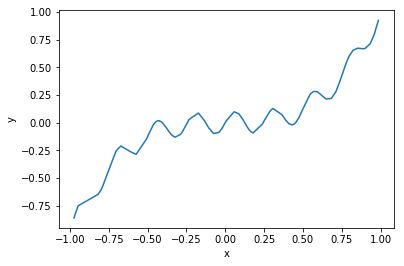

In [3]:
# Example function we will try to learn with calibration.
%matplotlib inline
def f(x):
    return np.power(x, 3) + 0.1*np.sin(x * math.pi * 8)

def gen_examples(n):
    x = np.random.uniform(-1, 1.0, size=n)
    x.sort()
    y = f(x)
    return (x,y)

# pwl_x_data and pwl_y_data contains a synthetic dataset.
n = 100
pwl_x_data, pwl_y_data = gen_examples(n)

plt.plot(pwl_x_data, pwl_y_data)
plt.ylabel("y")
plt.xlabel("x")

# Fitting a Piecewise Linear calibartor
In a piecewise linear (PWL) calibrator, input keypoints are given and output keypoints are TensorFlow variables.
So we fitting the output keypoints to minimize a loss function.

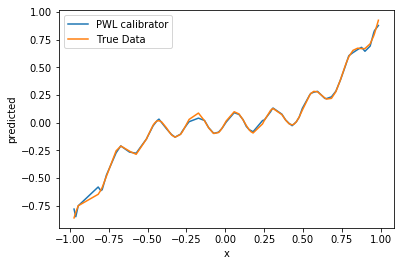

In [28]:
%matplotlib inline

# Let's reset the default graph to clean up the state.
tf.reset_default_graph()

# x is a placeholder for feeding 1d input data.
# We will feed the full datapoints (100), i.e., batch_size == 100.
x = tf.placeholder(dtype=tf.float32, shape=(n))
# y is a placeholder for feeding ground truth output.
y_ = tf.placeholder(dtype=tf.float32, shape=(n))


# To use calibrator, we need to initialize input and output keypoints.
# Here we'll use 50 number of keypoints in the PWL calibrator.
# Here 50 input keypoints will be uniformly spaced over [-1, 1], and 50 output
# keypoints will be uniformly spaced over [-0.5, 0.5].
#
# During training input keypoints will not be changed, but output keypoints will
# be changed to fit our data.
#
# Calibrator will clip the input outside of the input range [-1, 1], which means
# the input value less than -1 will be clipped to -1, and the input value
# greater than +1 will be clipped to +1. Feel free to change input_min and
# input_max to see this behavior.
num_keypoints = 50
kp_inits = tfl.uniform_keypoints_for_signal(
    num_keypoints=num_keypoints,
    input_min=-1.0,
    input_max=1.0,
    output_min=-0.5,
    output_max=0.5)

# Now we define PWL linear calibrator with 50 keypoints that calibrate the input
# tensor x (with shape [batch_size]), to the output tensor y (with shape
# [batch_size]). y[0] is the calibrated x[0], y[1] is the calibrated x[1], ....
# calibration_layer returns three elements:
#  1. output tensor
#  2. Projection operator
#  3. Regularization loss (scalar tensor)
# We'll cover the second and the third part in this notebook as well, so let's
# focus on the first.
(y, _, _) = tfl.calibration_layer(
    uncalibrated_tensor=x,
    num_keypoints=num_keypoints,
    keypoints_initializers=kp_inits)

# To train a calibrator, we define L2 loss.
# Here y_ is the ground truth.
loss = tf.reduce_mean(tf.square(y - y_))

# Now we define TensorFlow training operator.
# Here we'll use GradientDescentOptimizer with the initial learning rate 0.1.
# This train_op computes the gradient of L2 "loss" we just defined w.r.t. the 
# output keypoints in the calibrator, and update output keypoints value to
# minimize L2 "loss".
train_op = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)

sess = tf.Session()
# Before starting to train, we need to initialize variables in our computational
# graph.
sess.run(tf.global_variables_initializer())

# Apply gradient descent operator 1000 times.
for _ in range(1000):
    # Update output keypoints by feeding the full data into our computational
    # graph.
    sess.run(train_op, feed_dict={x: pwl_x_data, y_: pwl_y_data})

# Now training is done, let us fetch the prediction from our calibrator.
# predicted will contain numpy n-d array of predictions over pwl_x_data.
predicted = sess.run(y, feed_dict={x: pwl_x_data})

# Plot the response.
plt.plot(pwl_x_data, predicted)
plt.plot(pwl_x_data, pwl_y_data)
plt.ylabel("predicted")
plt.xlabel("x")
plt.legend(['PWL calibrator', 'True Data'])

# Bounded PWL calibrator
By default, output keypoints in the calibrator are not bounded.
In some cases, this is not desirable, especially when the output of the calibrator is fed into upper layer.
For example, a 2 x 2 lattice expects an input is in [0, 1] x [0, 1], so if calibrator output is fed into such a lattice layer,
it would be better for output keypoints to be in the range [0, 1].

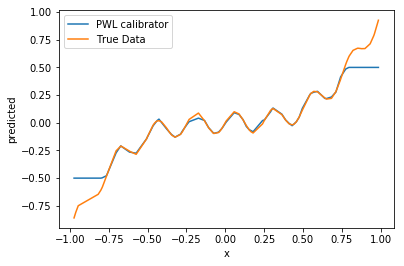

In [5]:
%matplotlib inline

# Same as before.
tf.reset_default_graph()

x = tf.placeholder(dtype=tf.float32, shape=(n))
y_ = tf.placeholder(dtype=tf.float32, shape=(n))

kp_inits = tfl.uniform_keypoints_for_signal(
    num_keypoints=50,
    input_min=-1.0,
    input_max=1.0,
    output_min=-0.5,
    output_max=0.5)

# Now we define a calibrator with "bound".
# By setting bound == True, we are making sure the output keypoints are inside
# the initial output range from kp_inits, [-0.5, 0.5].
# This is acheived by projection_op. projection_op is a collection of TensorFlow
# operators that find the output keypoints not in the range [-0.5, 0.5] and
# assign 0.5 for output keypoints larger than 0.5, -0.5 for output keypoints
# smaller than -0.5.
(y, projection_op, _) = tfl.calibration_layer(
    uncalibrated_tensor=x,
    num_keypoints=50,
    bound=True,
    keypoints_initializers=kp_inits)

# Sqaured loss
loss = tf.reduce_mean(tf.square(y - y_))

# Minimize!
train_op = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
# Iterate 1000 times
for _ in range(1000):
    # Apply gradient.
    sess.run(train_op, feed_dict={x: pwl_x_data, y_: pwl_y_data})
    # Then apply projection. This is projected SGD.
    sess.run(projection_op)

predicted = sess.run(y, feed_dict={x: pwl_x_data})

# In the plot, we should see that the predictions are in the range [-0.5, 0.5].
plt.plot(pwl_x_data, predicted)
plt.plot(pwl_x_data, pwl_y_data)
plt.ylabel("predicted")
plt.xlabel("x")
plt.legend(['PWL calibrator', 'True Data'])

# Bounded monotonic PWL calibrator
You can also set monotonicity in each calibrator.

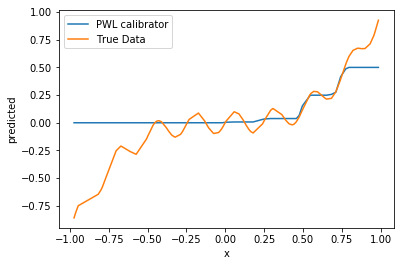

In [29]:
%matplotlib inline

tf.reset_default_graph()

x = tf.placeholder(dtype=tf.float32, shape=(n))
y_ = tf.placeholder(dtype=tf.float32, shape=(n))

kp_inits = tfl.uniform_keypoints_for_signal(
    num_keypoints=50,
    input_min=-1.0,
    input_max=1.0,
    output_min=0.0,
    output_max=0.5)

# Monotonically increasing 1d calibrator.
# In addition to the bound, now let's make the calibrator monotonic.
# Since we set monotonic to +1, projection_op now contains not only the bounding
# projection, but also monotonicity projection.
(y, projection_op, _) = tfl.calibration_layer(
    uncalibrated_tensor=x,
    num_keypoints=50,
    bound=True,
    monotonic=+1,
    keypoints_initializers=kp_inits)

# Sqaured loss
loss = tf.reduce_mean(tf.square(y - y_))

# Minimize!
train_op = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# Iterate 1000 times
for _ in range(1000):
    # Apply gradient.
    sess.run(train_op, feed_dict={x: pwl_x_data, y_: pwl_y_data})
    # Apply projection.
    sess.run(projection_op)

predicted = sess.run(y, feed_dict={x: pwl_x_data})

# Now in the plot, we should see monotonically increasing predictions.
plt.plot(pwl_x_data, predicted)
plt.plot(pwl_x_data, pwl_y_data)
plt.ylabel("predicted")
plt.xlabel("x")
plt.legend(['PWL calibrator', 'True Data'])

# Laplacian regularizer
Now let's add the Laplacian regularizer.
Laplacian regularizer penalizes the change in consecutive output keypoint values.
Therefore we can get much smoother 1d calibration result.

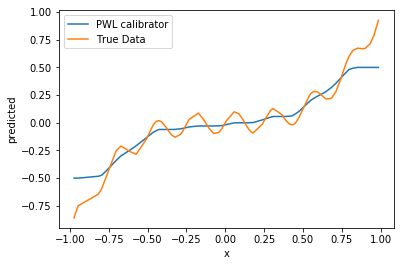

In [35]:
%matplotlib inline

tf.reset_default_graph()

x = tf.placeholder(dtype=tf.float32, shape=(n))
y_ = tf.placeholder(dtype=tf.float32, shape=(n))

kp_inits = tfl.uniform_keypoints_for_signal(
    num_keypoints=50,
    input_min=-1.0,
    input_max=1.0,
    output_min=-0.5,
    output_max=0.5)

# Piecewise linear calibration.
# Here we set L2 Laplacian regularization.
# L2 Laplacian regularization ==
#  ||output_keypoints[1:end] - output_keypoints[0:-2]||_2^2
# which penalizes changes in consecutive output keypoints (the slope) in the
# calibrator.
# regularization is 1d scalar, and we expect this to be added to the loss.
(y, projection_op, regularization) = tfl.calibration_layer(
    uncalibrated_tensor=x,
    num_keypoints=50,
    bound=True,
    monotonic=+1,
    l2_laplacian_reg=0.1,
    keypoints_initializers=kp_inits)

# loss == squared loss + regularzation.
loss = tf.reduce_mean(tf.square(y - y_))
objective = loss + regularization

# Minimize!
train_op = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(objective)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# Iterate 10 times
for _ in range(1000):
    # Apply gradient.
    sess.run(train_op, feed_dict={x: pwl_x_data, y_: pwl_y_data})
    sess.run(projection_op)

predicted = sess.run(y, feed_dict={x: pwl_x_data})
# Now we expect a smoother calibrator.
plt.plot(pwl_x_data, predicted)
plt.plot(pwl_x_data, pwl_y_data)
plt.ylabel("predicted")
plt.xlabel("x")
plt.legend(['PWL calibrator', 'True Data'])